In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generating the image
In order to do image reconstruction, we need an image. Here we create it using NumPy. The image will consist of a square and two circles. Simple.

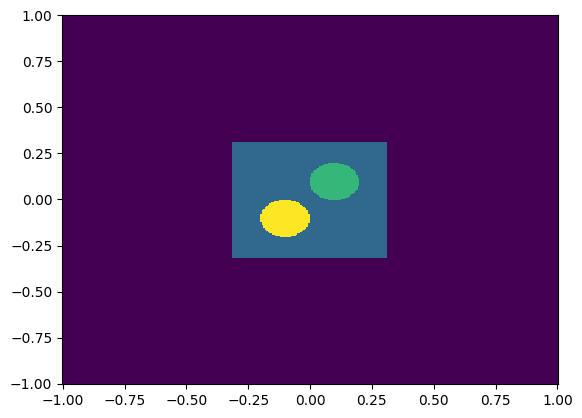

In [12]:
image = np.ones([100, 100])
diag = np.size(np.diag(image)//2)
image = np.pad(image, pad_width=diag+10)
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)
image[(xv - .1)**2 + (yv - .1)**2 < .01] = 2
image[(xv + .1)**2 + (yv + .1)**2 < .01] = 3

fig, ax = plt.subplots()
ax.pcolor(xv, yv, image, shading='auto')
plt.show()


## Rotation
The goal is to simulate CT machine so we need rotation. In this case, it's easiest to just rotate the image. We can do that with SKImage module (I want to avoid writing my own rotate method).

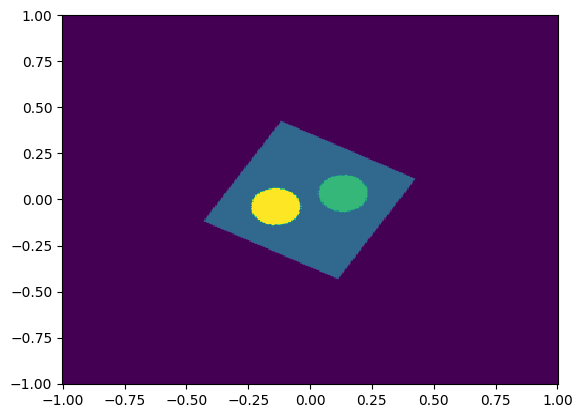

In [14]:
from skimage.transform import rotate

image_rot = rotate(image, 30)
fig, ax = plt.subplots()
ax.pcolor(xv, yv, image_rot, shading='auto')
plt.show()

## Sinogram
CT produces a sinogram which is then reconstructed.

In [17]:
angles = (np.arange(0, 180, 10) * np.pi) / 180.0  # in radians, we are not barbarians here.